In [ ]:
import numpy as np
from IPython.display import clear_output
import cudf
import cuml
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import sklearn.metrics
from scipy import sparse
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
from sklearn.metrics import *

import re
from nltk.stem import WordNetLemmatizer
import nltk

import cupy as cp
import cupyx

import warnings
warnings.filterwarnings('ignore')

print('RAPIDS',cuml.__version__)

In [14]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [17]:
print("Train DataFrame:")
print(train_df.info())
print("\nTest DataFrame:")
print(test_df.info())

Train DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36696 entries, 0 to 36695
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              36696 non-null  int64 
 1   QuestionId          36696 non-null  int64 
 2   QuestionText        36696 non-null  object
 3   MC_Answer           36696 non-null  object
 4   StudentExplanation  36696 non-null  object
 5   Category            36696 non-null  object
 6   Misconception       9860 non-null   object
dtypes: int64(2), object(5)
memory usage: 2.0+ MB
None

Test DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   row_id              3 non-null      int64 
 1   QuestionId          3 non-null      int64 
 2   QuestionText        3 non-null      object
 3   MC_Answer           3 non-

In [6]:
train_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NaN
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NaN
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NaN


In [18]:
test_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si..."
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.


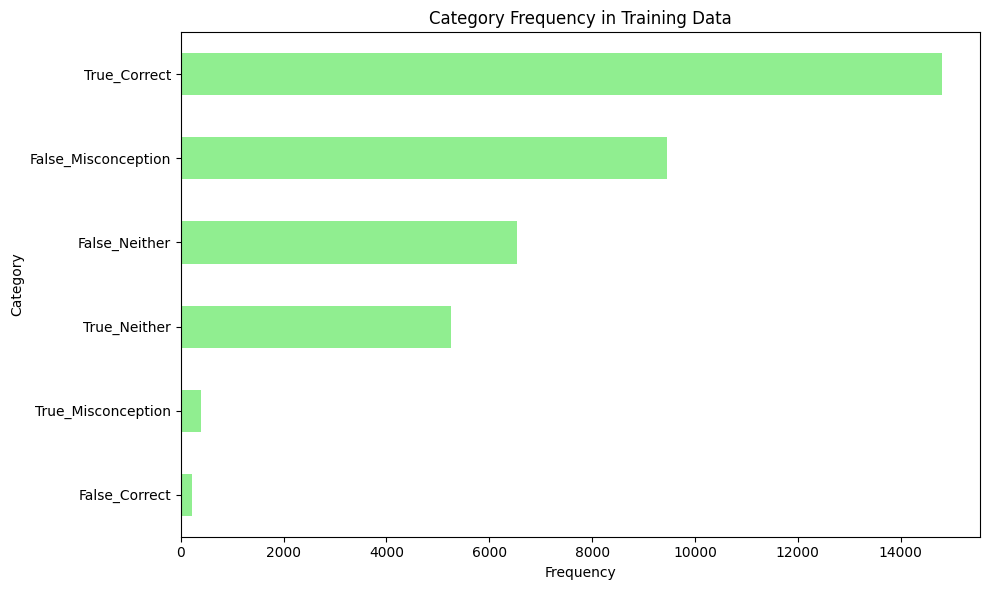

In [21]:
import matplotlib.pyplot as plt

# Get value counts
categories = train_df.Category.value_counts()

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
categories.plot(kind='barh', color='lightgreen')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.title('Category Frequency in Training Data')
plt.gca().invert_yaxis()  # Most frequent at top
plt.tight_layout()
plt.show()


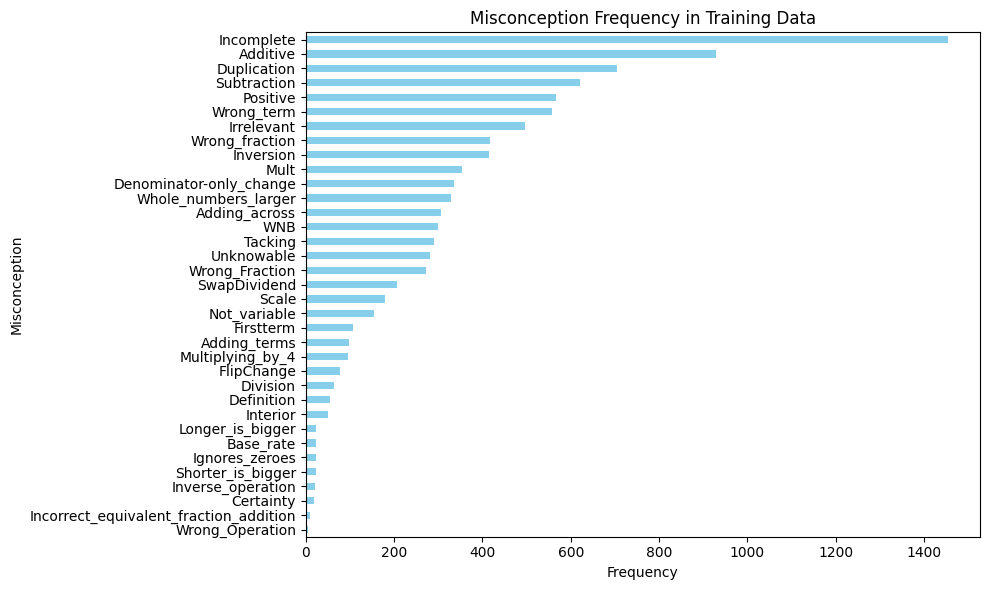

In [20]:
# Get value counts
misconceptions = train_df.Misconception.value_counts()

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
misconceptions.plot(kind='barh', color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Misconception')
plt.title('Misconception Frequency in Training Data')
plt.gca().invert_yaxis()  # Most frequent at top
plt.tight_layout()
plt.show()


In [27]:
print("Training Questions Unique")
print(train_df.QuestionId.nunique())
print("Testing Questions Unique")
print(test_df.QuestionId.nunique())

Training Questions Unique
15
Testing Questions Unique
2


In [38]:
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

Train Shape: (36696, 8)
Test Shape: (3, 5)


In [30]:
train_df.Misconception = train_df.Misconception.fillna("NA")
train_df['label'] = train_df.Category + ":" + train_df.Misconception

In [31]:
train_df['label'].value_counts()

label
True_Correct:NA                            14802
False_Neither:NA                            6542
True_Neither:NA                             5265
False_Misconception:Incomplete              1446
False_Misconception:Additive                 891
                                           ...  
True_Misconception:Not_variable                1
True_Misconception:Whole_numbers_larger        1
True_Misconception:Adding_across               1
True_Misconception:Longer_is_bigger            1
True_Misconception:Base_rate                   1
Name: count, Length: 65, dtype: int64

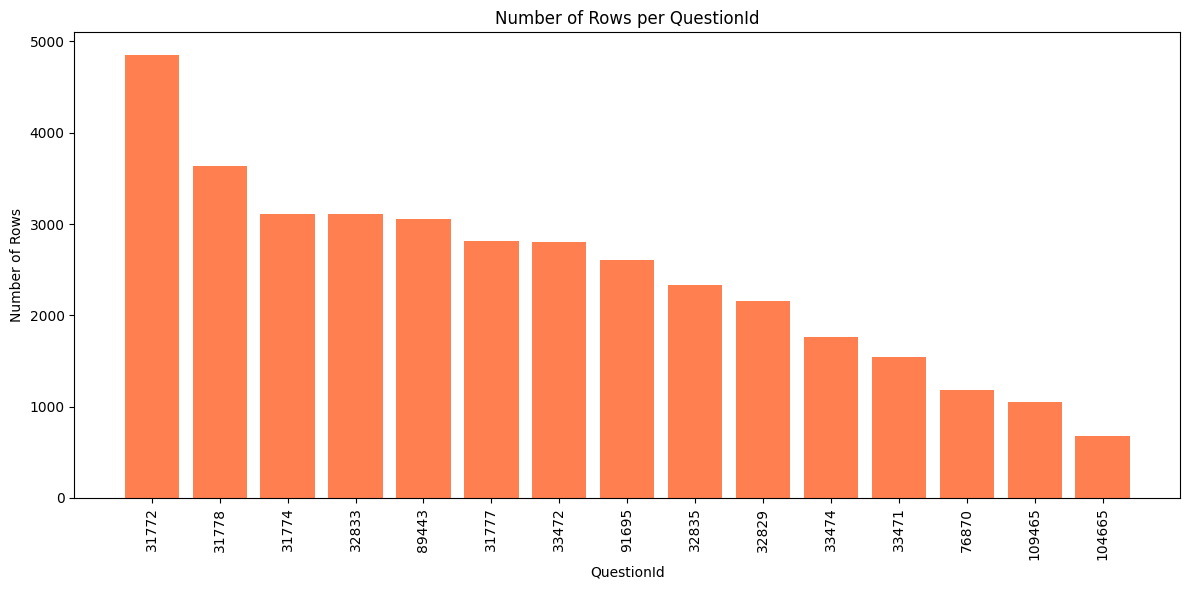

In [37]:
import matplotlib.pyplot as plt

question_counts = train_df.groupby("QuestionId").count().reset_index()
counts = question_counts[['QuestionId', 'row_id']]
counts = counts.sort_values('row_id', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(counts['QuestionId'].astype(str), counts['row_id'], color='coral')
plt.xlabel('QuestionId')
plt.ylabel('Number of Rows')
plt.title('Number of Rows per QuestionId')
plt.xticks(rotation=90)  # Rotate labels if too many
plt.tight_layout()
plt.show()


In [51]:
train_df.head()

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA


In [68]:
train_df[(train_df.Category.str.contains("True"))].groupby(['QuestionId', 'MC_Answer'])['row_id'].count()

QuestionId  MC_Answer                           
31772       \( \frac{1}{3} \)                       2348
31774       \( \frac{1}{12} \)                      1918
31777       \( 72 \)                                1798
31778       \( 6 \)                                 1749
            \( 9 \)                                   12
32829       \( 12 \)                                1716
32833       \( 3 \frac{1}{3} \)                     1601
32835       \( 6.2 \)                               1674
33471       \( 15 \)                                 874
33472       \( \frac{11}{15} \)                     1651
33474       \( \frac{1}{3} \times \frac{2}{3} \)     630
76870       \( 10 \)                                 508
89443       \( -3 \)                                1394
91695       \( 26 \)                                1547
104665      \( 48 \) hours                           497
109465      Likely                                   553
Name: row_id, dtype: int64

In [71]:
train_df[(train_df.Category.str.contains("True")) & (train_df.MC_Answer=="\( 9 \)")]

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,label
14280,14280,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),"Because 10 is 2 / 3 of 15, and 2 is 6.",True_Neither,NA,True_Neither:NA
14305,14305,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),"I divided 9/15 by 3, then got 3/5 and timsed i...",True_Correct,NA,True_Correct:NA
14321,14321,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),I think it's C because 6/10 is the same as 9/15.,True_Correct,NA,True_Correct:NA
14335,14335,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),Il believe that is the ansewer because I calcu...,True_Neither,NA,True_Neither:NA
14338,14338,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),It is six because they are both equal to 3over5.,True_Correct,NA,True_Correct:NA
14352,14352,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),"To get a denominator of 10, we need to divide ...",True_Correct,NA,True_Correct:NA
14355,14355,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),You have to change the denominator to 150 then...,True_Neither,NA,True_Neither:NA
14403,14403,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),i think this is because 9/15=18/30 and 6/10 =1...,True_Correct,NA,True_Correct:NA
14407,14407,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),if you simplify it to 3/5 then you get 9/15.,True_Neither,NA,True_Neither:NA
14412,14412,31778,\( \frac{A}{10}=\frac{9}{15} \) What is the va...,\( 9 \),since 9 - 3 = 6h are so i't must be these ohne!,True_Neither,NA,True_Neither:NA


In [79]:
train_df.loc[train_df[(train_df.Category.str.contains("True")) & (train_df.MC_Answer=="\( 9 \)")].index, 'MC_Answer'] = '\( 6 \)'

In [91]:
truth_table = train_df[(train_df.Category.str.contains("True"))][['QuestionId', 'MC_Answer']].drop_duplicates()

In [94]:
map_target1 = train_df['Category'].value_counts().to_frame()
map_target1['count'] = np.arange(len(map_target1))
map_target1 = map_target1.to_dict()['count']

map_target2 = train_df['Misconception'].value_counts().to_frame()
map_target2['count'] = np.arange(len(map_target2))
map_target2 = map_target2.to_dict()['count']

print(map_target1)
print(map_target2)

{'True_Correct': 0, 'False_Misconception': 1, 'False_Neither': 2, 'True_Neither': 3, 'True_Misconception': 4, 'False_Correct': 5}
{'NA': 0, 'Incomplete': 1, 'Additive': 2, 'Duplication': 3, 'Subtraction': 4, 'Positive': 5, 'Wrong_term': 6, 'Irrelevant': 7, 'Wrong_fraction': 8, 'Inversion': 9, 'Mult': 10, 'Denominator-only_change': 11, 'Whole_numbers_larger': 12, 'Adding_across': 13, 'WNB': 14, 'Tacking': 15, 'Unknowable': 16, 'Wrong_Fraction': 17, 'SwapDividend': 18, 'Scale': 19, 'Not_variable': 20, 'Firstterm': 21, 'Adding_terms': 22, 'Multiplying_by_4': 23, 'FlipChange': 24, 'Division': 25, 'Definition': 26, 'Interior': 27, 'Longer_is_bigger': 28, 'Base_rate': 29, 'Ignores_zeroes': 30, 'Shorter_is_bigger': 31, 'Inverse_operation': 32, 'Certainty': 33, 'Incorrect_equivalent_fraction_addition': 34, 'Wrong_Operation': 35}


In [95]:
train_df['target1'] = train_df['Category'].map(map_target1)
train_df['target2'] = train_df['Misconception'].map(map_target2)

train_df['Category'].value_counts()

Category
True_Correct           14802
False_Misconception     9457
False_Neither           6542
True_Neither            5265
True_Misconception       403
False_Correct            227
Name: count, dtype: int64

In [97]:
train_df['Sentence'] = "Question:" + train_df['QuestionText'].astype(str) + "Answer:" + train_df['MC_Answer'].astype(str) + 'Explanation:'+train_df['StudentExplanation'].astype(str)
test_df['Sentence'] = "Question:" + test_df['QuestionText'].astype(str) + "Answer:" + test_df['MC_Answer'].astype(str) + 'Explanation:'+test_df['StudentExplanation'].astype(str)

In [100]:
import re
clean_newlines = re.compile(r'\n+')
clean_spaces = re.compile(r'\s+')
clean_punct = re.compile(r'[^a-zA-Z0-9\s_]')  

def fast_clean(text):
    text = clean_newlines.sub(' ', text)
    text = clean_spaces.sub(' ', text)
    text = clean_punct.sub('', text)
    return text.strip().lower()

In [102]:
train_df['Sentence'] = train_df['Sentence'].apply(fast_clean)
test_df['Sentence'] = test_df['Sentence'].apply(fast_clean)

In [108]:
lemmatizer = WordNetLemmatizer()

def fast_lemmatize(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

train_df['Sentence'] = train_df['Sentence'].apply(fast_lemmatize)
test_df['Sentence'] = test_df['Sentence'].apply(fast_lemmatize)

print("# \n ---------------------------------------------------------------")
print("# CHAR VECTORIZER StudentExplanation")
print("# ---------------------------------------------------------------\n")

vec_student = TfidfVectorizer(ngram_range=(1, 4), analyzer='char', max_features=2000, max_df=0.95, min_df=2, sublinear_tf=True)
vec_student.fit(pd.concat([train_df['StudentExplanation'], test_df['StudentExplanation']]))

train_stu = vec_student.transform(train_df['StudentExplanation'])
test_stu = vec_student.transform(test_df['StudentExplanation'])

print("# \n---------------------------------------------------------------")
print("# CHAR_WB VECTORIZER ")
print("# ---------------------------------------------------------------")

vec_char = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5), max_features=5000, max_df=0.95, min_df=2)
vec_char.fit(pd.concat([train_df['Sentence'], test_df['Sentence']]))

train_char = vec_char.transform(train_df['Sentence'])
test_char = vec_char.transform(test_df['Sentence'])

print("# \n---------------------------------------------------------------")
print("# CHAR VECTORIZER ")
print("# ---------------------------------------------------------------")

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 4), max_df=0.95, min_df=2)

total_embedding = pd.concat([train_df['Sentence'], test_df['Sentence']])
vectorizer.fit(total_embedding)

train_embed = vectorizer.transform(train_df['Sentence'])
test_embed = vectorizer.transform(test_df['Sentence'])

train_embeddings = sparse.hstack([train_stu, train_char, train_embed])
test_embeddings = sparse.hstack([test_stu, test_char, test_embed])

train_embeddings = sparse.csr_matrix(train_embeddings)
test_embeddings = sparse.csr_matrix(test_embeddings)

print(f"Train Final Shape: {train_embeddings.shape}")
print(f"Test Final Shape: {test_embeddings.shape}")

# 
 ---------------------------------------------------------------
# CHAR VECTORIZER StudentExplanation
# ---------------------------------------------------------------

# 
---------------------------------------------------------------
# CHAR_WB VECTORIZER 
# ---------------------------------------------------------------
# 
---------------------------------------------------------------
# CHAR VECTORIZER 
# ---------------------------------------------------------------
Train Final Shape: (36696, 31865)
Test Final Shape: (3, 31865)


In [ ]:
p = {'C': 21.50207632521388, 'max_iter': 9700, 'tol': 1.2363026579561568e-06}

SEED = 0

oof_1 = np.zeros((len(train_df), len(map_target1)))
pred_1 = np.zeros((len(test_df), len(map_target1)))

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
for i, (train_index, valid_index) in enumerate(skf.split(train_embeddings, train_df['target1'])):
    print(f"Fold {i}, {len(train_index)}, {len(valid_index)}:")
    model = cuml.LogisticRegression(**p,class_weight='balanced', fit_intercept = True, penalty = 'l2', solver ='qn')
    model.fit(train_embeddings[train_index], train_df['target1'].iloc[train_index])
    oof_1[valid_index] = model.predict_proba(train_embeddings[valid_index]).get()
    pred_1 += (model.predict_proba(test_embeddings).get() / 10.)

print("ACC:", np.mean( train_df['target1'] == np.argmax(oof_1, 1) ) )
print("F1:", sklearn.metrics.f1_score(train_df['target1'] , np.argmax(oof_1, 1), average='weighted')) # 0.8290

In [ ]:
import scipy 

model = TfidfVectorizer(ngram_range=(1, 4), analyzer='char', max_df=0.95, min_df=2)

model.fit(pd.concat([train_df, test_df]).sentence)

train_embeddings = model.transform(train_df.sentence)
test_embeddings = model.transform(test_df.sentence)
clear_output(wait=True)

train_embeddings = scipy.sparse.csr_matrix(train_embeddings)
test_embeddings = scipy.sparse.csr_matrix(test_embeddings)

print('Train sparse shape is',train_embeddings.shape)
print('Test sparse shape is',test_embeddings.shape)

In [ ]:
p2 = {'C': 9.845314136706442, 'max_iter': 1500, 'tol': 0.00013445181991934277}

oof_2 = np.zeros((len(train_df), len(map_target2)))
pred_2 = np.zeros((len(test_df), len(map_target2)))

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
for i, (train_index, valid_index) in enumerate(skf.split(train_embeddings, train_df['target2'])):
    print(f"Fold {i}, {len(train_index)}, {len(valid_index)}:")
    model = cuml.LogisticRegression(**p2, class_weight='balanced', fit_intercept = True, penalty = 'l2', solver ='qn')
    model.fit(train_embeddings[train_index], train_df['target2'].iloc[train_index])
    oof_2[valid_index] = model.predict_proba(train_embeddings[valid_index]).get()
    pred_2 += (model.predict_proba(test_embeddings).get() / 10.)

print("ACC:", np.mean( train_df['target2'] == np.argmax(oof_2, 1) ) )
print("F1:", sklearn.metrics.f1_score(train_df['target2'] , np.argmax(oof_2, 1), average='weighted')) # 0.9236

In [ ]:
map_inverse1 = {map_target1[k]:k for k in map_target1}
map_inverse2 = {map_target2[k]:k for k in map_target2}

In [ ]:
oof_2[:, 0] = 0
predicted1 = np.argsort(-oof_1, 1)[:,:3]
predicted2 = np.argsort(-oof_2, 1)[:,:3]

In [ ]:
predict = []
for i in range(len(predicted1)):
    pred = []
    for j in range(3):
        p1 = map_inverse1[predicted1[i, j]]
        p2 = map_inverse2[predicted2[i, 0]]
        if 'Misconception' in p1:
            pred.append(p1 + ":" + p2 )
        else:
            pred.append(p1 + ":NA")
    predict.append(pred)

print('ACCURACY_1')
print( np.mean(train_df['target_cat'] == [p[0] for p in predict]) )
print('ACCURACY_2')
print( np.mean(train_df['target_cat'] == [p[1] for p in predict]) )
print('ACCURACY_3')
print( np.mean(train_df['target_cat'] == [p[2] for p in predict]) )

In [ ]:

def map3(target_list, pred_list):
    score = 0.
    for t, p in zip(target_list, pred_list):
        if t == p[0]:
            score+=1.
        elif t == p[1]:
            score+=1/2
        elif t == p[2]:
            score+=1/3
    return score / len(target_list)
        
print(f"MAP@3: {map3(train_df['target_cat'].tolist(), predict)}") # 0.9017

In [ ]:
pred_2[:, 0] = 0
predicted1 = np.argsort(-pred_1, 1)[:,:3]
predicted2 = np.argsort(-pred_2, 1)[:,:3]

predict = []
for i in range(len(predicted1)):
    pred = []
    for j in range(3):
        p1 = map_inverse1[predicted1[i, j]]
        p2 = map_inverse2[predicted2[i, 0]]        
        if 'Misconception' in p1:
            pred.append(p1 + ":" + p2 )
        else:
            pred.append(p1 + ":NA")
    predict.append(" ".join(pred))

sub = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/sample_submission.csv")
sub['Category:Misconception'] = predict
sub.to_csv("submission.csv", index=False)
sub